In [295]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from scipy.stats import linregress
import pandas as pd

import pathlib
import sys


from scipy.stats import kstest, norm, probplot, normaltest, shapiro
from scipy.stats.distributions import lognorm
import statsmodels.api as sm

# home = pathlib.Path().resolve().parent
# path = str(pathlib.Path(home, r'Andrey\new_workspace'))
home = pathlib.Path().resolve().parent
path = str(pathlib.Path(home, r'Andrey'))
sys.path.insert(0, home)

from src.mixture_fit import gen_data, fits, sum_exp_curv, fit, sum_exp, loss_function, right_order
from src.data_loading import load_data
from src.optimal_number import optimal_params
from src.log_data_analysis import log_estimate, bounds
from src.errors import bootstrap_resudial, bootstrap_residual
from src.bootstrapping import bootstrap

import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning) 


%matplotlib widget

In [59]:
data_water = pd.read_csv(r'D:\Programms\Jupyter\NPM\Andrey\data\DOSY-R2-1-4-DMSO-5points-1000raz-integrals.txt', sep='\t')
# data['Area'] = data['Area'].apply(lambda x: x.replace(',', '.')).astype(float)
x_water, y_water = data_water['Z'].values, data_water['Integral'].values

x_water = x_water.reshape(-1, 5)
y_water = y_water.reshape(-1, 5)

y_water = y_water / y_water.max(1).reshape(-1, 1)
x_water = x_water / 1e6

mask = np.ones(851, dtype=bool)
mask[:100] = False
mask[200:450] = False
mask[600:750] = False
x_water = x_water[mask]
y_water = y_water[mask]

13237.01501066156


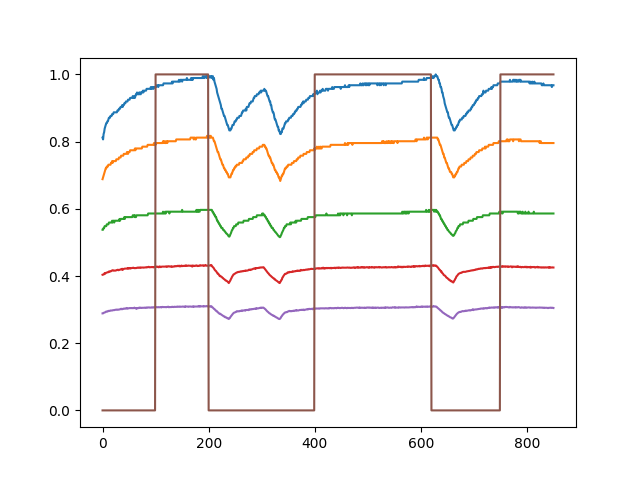

In [362]:
data = pd.read_csv(r'D:\Programms\Jupyter\NPM\Andrey\data\DOSY-R2-1-4-DMSO-5points-1000raz-integral-3.43-3.53.txt', sep='\t')
data['Area'] = data['Area'].apply(lambda x: x.replace(',', '.')).astype(float)
x, y = data['Z'].values, data['Area'].values

x = x.reshape(-1, 5)
y = y.reshape(-1, 5)

print(np.sqrt(y.max(1).mean()))

# y = y / y.max(1).reshape(-1, 1)
y = y / y.max()
x = x / 1e6

mask = np.ones(851, dtype=bool)
mask[:100] = False
mask[200:400] = False
mask[620:750] = False

# mask = (y.T[-1] > 0.305) * (y.T[0] > 0.9)

x = x[mask]
y_print = y.copy()
y = y[mask]

plt.close()
plt.plot(y_print)
plt.plot(mask)
plt.show()

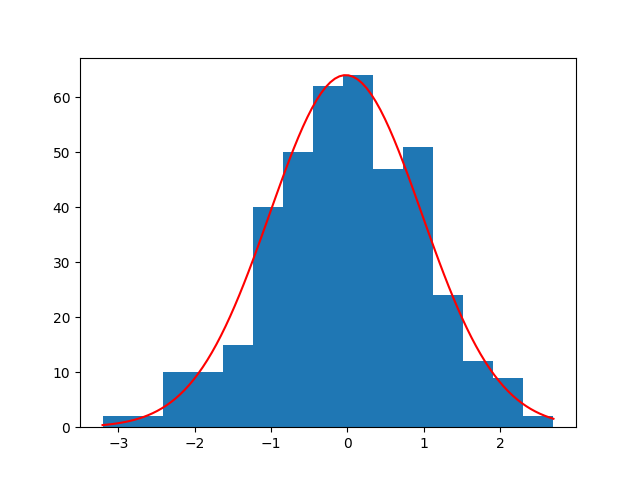

In [315]:
test = np.random.normal(0, 1, 400)

plt.close()
_hist_data, _bins, _ = plt.hist(test, bins=15, histtype='stepfilled')
x_space = np.linspace(_bins[0], _bins[-1], 100)
norm_dist = norm.pdf(x_space, test.mean(), test.std())
plt.plot(x_space, norm_dist/norm_dist.max()*_hist_data.max(), c='red')
plt.show()

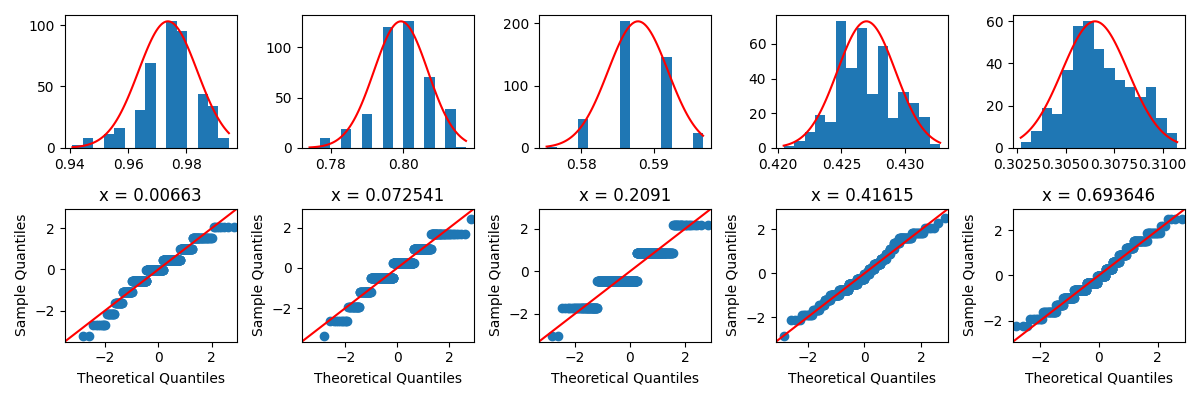

In [306]:
plt.close()
plt.figure(figsize=(12,4))
for i in range(5):
    plt.subplot(2, 5, i + 1)
    _hist_data, _bins, _ = plt.hist(y.T[i], bins=15, histtype='stepfilled')
    x_space = np.linspace(_bins[0], _bins[-1], 100)
    # norm_dist = norm.pdf(x_space, *norm.fit(y.T[i]))
    norm_dist = norm.pdf(x_space, y.T[i].mean(), y.T[i].std())
    norm_dist = norm_dist/norm_dist.max() * _hist_data.max()
    plt.plot(x_space, norm_dist, c='red')
    # plt.yscale('log')

    plt.subplot(2, 5, 5 + i+1)
    _ = sm.qqplot((y.T[i] - y.T[i].mean())/y.T[i].std(), line='45', ax=plt.gca())
    # plt.plot(np.linspace(1.8e8, 1.84e8, 10), 1e10*lognorm.pdf(np.linspace(1.8e8, 1.84e8, 10), *lognorm.fit(y.T[0])))
    plt.title(f'x = {x[0][i]}', fontsize=12)
plt.tight_layout()
plt.show()

In [12]:
i = 2
# ks_statistic, p_value = kstest((y.T[i] - y.T[i].mean())/y.T[i].std(), 'norm')
# print(ks_statistic, p_value)
shapiro((y.T[i] - y.T[i].mean())/y.T[i].std())

ShapiroResult(statistic=0.9602541923522949, pvalue=3.677190463236002e-08)

In [188]:
folder = pathlib.Path(path,'data', 'R2_5times')
y_arr_norm = []
y_arr = []
for i in range(1, 6):
    data_path = pathlib.Path(folder, f'DOSY-R2-1-4-DMSO-128points-{i}.txt')
    x1, y1 = load_data(data_path)
    x2, y2 = np.loadtxt(data_path, skiprows=2, usecols=(1,2)).T
    y_arr_norm.append(y1)
    y_arr.append(y2)

y_arr_norm = np.vstack(y_arr_norm)
y_arr = np.vstack(y_arr)

In [394]:
y_arr

array([[14598.748, 13880.66 , 13393.884, 12894.482, 12422.674, 11971.412,
        11559.419, 11146.761, 10738.327, 10343.375,  9988.592,  9638.619,
         9299.034,  8962.78 ,  8651.618,  8344.674,  8051.433,  7763.094,
         7480.65 ,  7237.515,  6964.709,  6719.563,  6475.756,  6245.174,
         6022.552,  5815.39 ,  5612.511,  5421.904,  5224.818,  5038.081,
         4867.05 ,  4687.488,  4518.478,  4364.605,  4204.947,  4063.705,
         3907.315,  3767.52 ,  3641.028,  3516.573,  3386.753,  3266.62 ,
         3146.497,  3041.911,  2933.898,  2831.003,  2720.224,  2630.054,
         2538.24 ,  2448.672,  2363.091,  2279.912,  2193.928,  2114.876,
         2041.357,  1968.345,  1903.672,  1836.275,  1765.658,  1705.157,
         1643.306,  1589.068,  1528.346,  1476.696,  1421.295,  1372.706,
         1322.019,  1275.561,  1231.906,  1187.916,  1148.201,  1103.498,
         1065.147,  1028.063,   989.54 ,   952.499,   915.191,   888.117,
          860.756,   823.892,   794.61

In [323]:
cov_matrix = np.cov(y_arr.T)
var1 = cov_matrix[0,0] / y_arr.mean(0)[0] ** 2
var2 = np.diag(cov_matrix)[1:] / y_arr.mean(0)[1:] ** 2
covar = cov_matrix[0, 1:]/(y_arr.mean(0)[0] * y_arr.mean(0)[1:])

In [324]:
theor_std = (var1 + var2 - 2 * covar) ** 0.5

In [478]:
def sigmoid(x, border=1.6):
    return 1 / (1 + np.exp(-3 * (x-border)))

def error_estimate(x, sigma=0.018, est_coeff = 1.1):
    x1 = x * est_coeff / 1.1 
    return ((0.018*np.exp(-0.94 * x1)+0.0002) * sigmoid(x1) + (0.013*np.exp(-6 * x1)+0.0051) * (1 - sigmoid(x1)))/0.018 * sigma

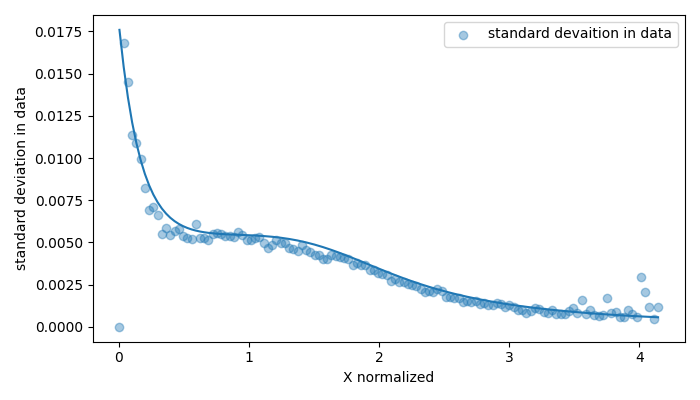

In [390]:
plt.close()
plt.figure(figsize=(7,4))
# plt.scatter(x1, y_arr_norm.std(0)/y_arr_norm.mean(0))
# plt.scatter(x1[1:], theor_std)
# plt.scatter(x1[1:], theor_std * y_arr_norm.mean(0)[1:], alpha=0.4, label='theoretical standard deviation with correlation')
plt.scatter(x1, y_arr_norm.std(0), alpha=0.4, label='standard devaition in data')
# plt.plot(x1, error_estimate(x1)/np.exp(-1.1*x1))
plt.plot(x1, error_estimate(x1))
# plt.scatter(x[0], y.std(0) * 3.126)
# plt.plot(x1, 0.013*np.exp(-6 * x1)+0.005)
plt.ylabel('standard deviation in data')
plt.xlabel('X normalized')
plt.tight_layout()
plt.legend()
plt.show()

In [471]:
y_test_norm = []
y_test = []
for i in range(5):
    _test = 14300 * np.exp(-0.3 * x1) * np.random.normal(1, 0.043, len(x1))
    y_test.append(_test)
    y_test_norm.append(_test/_test.max())

y_test = np.vstack(y_test)
y_test_norm = np.vstack(y_test_norm)

In [465]:
y1_test = y_test_norm.std(0)

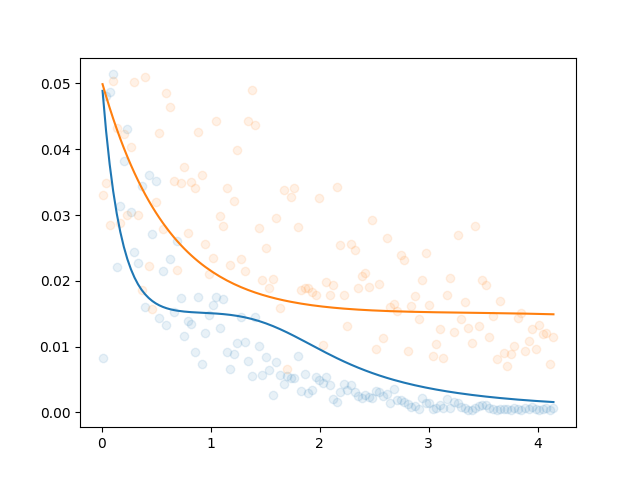

In [480]:
plt.close()
plt.scatter(x1, y1_test, alpha=0.1)
plt.plot(x1, error_estimate(x1, sigma=0.05))
# plt.scatter(x1, y1_test, alpha=0.1)
plt.scatter(x1, y_test_norm.std(0), alpha=0.1)
plt.plot(x1, error_estimate(x1, sigma=0.05, est_coeff=0.3))
# plt.plot(x1, error_estimate(x1))
# plt.plot(x1, (0.05*np.exp(-1.1 * x1)))
# plt.scatter(x1, y_test_norm.std(0), alpha=0.1)
# plt.scatter(x1, y_arr_norm.std(0)/y_arr.mean(0))
# plt.scatter(x1, 0.00005 * y_arr.std(0)/y_arr.mean(0))
# plt.scatter(x1)
plt.show()

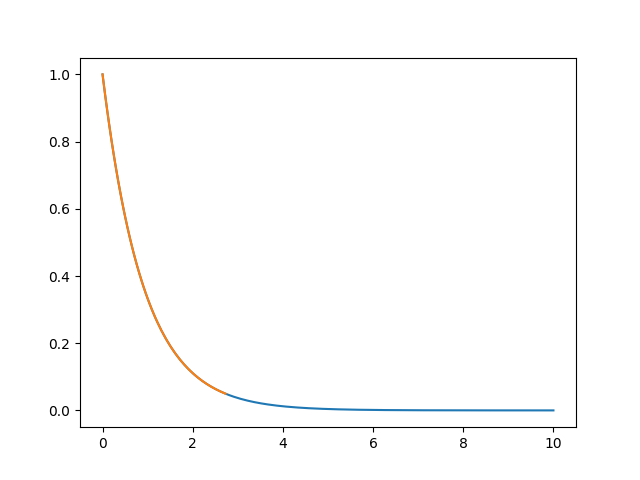

In [464]:
plt.close()
x_range = np.linspace(0, 10, 200)
plt.plot(x_range, np.exp(-1.1 * x_range))
plt.plot(x_range/1.1*0.3, np.exp(-0.3 * x_range))
plt.show()